# Parte 1: Diseño de un Modelo de Machine Translation

Supuestos:

* Ingresan 3 secuencias de largo 6 al Encoder.
* Cada Token se separa por espacios, tanto en español como en **Xanith**. Por simplicidad, no tome en consideración los signos de puntuación. En Xanith, el guión (-) es parte de la palabra y no debe ser eliminado.
* Se considerará el número de palabras más comunes del español, es decir, **10.000**. En el caso del **Xanith**, al ser un idioma mucho más simple, cuenta con cerca de **1.000** palabras

### (a) Dibuje el esquema de la arquitectura utilizando GRUs. Especifique a su criterio, **todos los hiperparámetros** necesarios para esta tarea.

Se proporciona imagen de la arquitectura utilizando GRU de dos layers. Se utilizó canva para su elaboración.

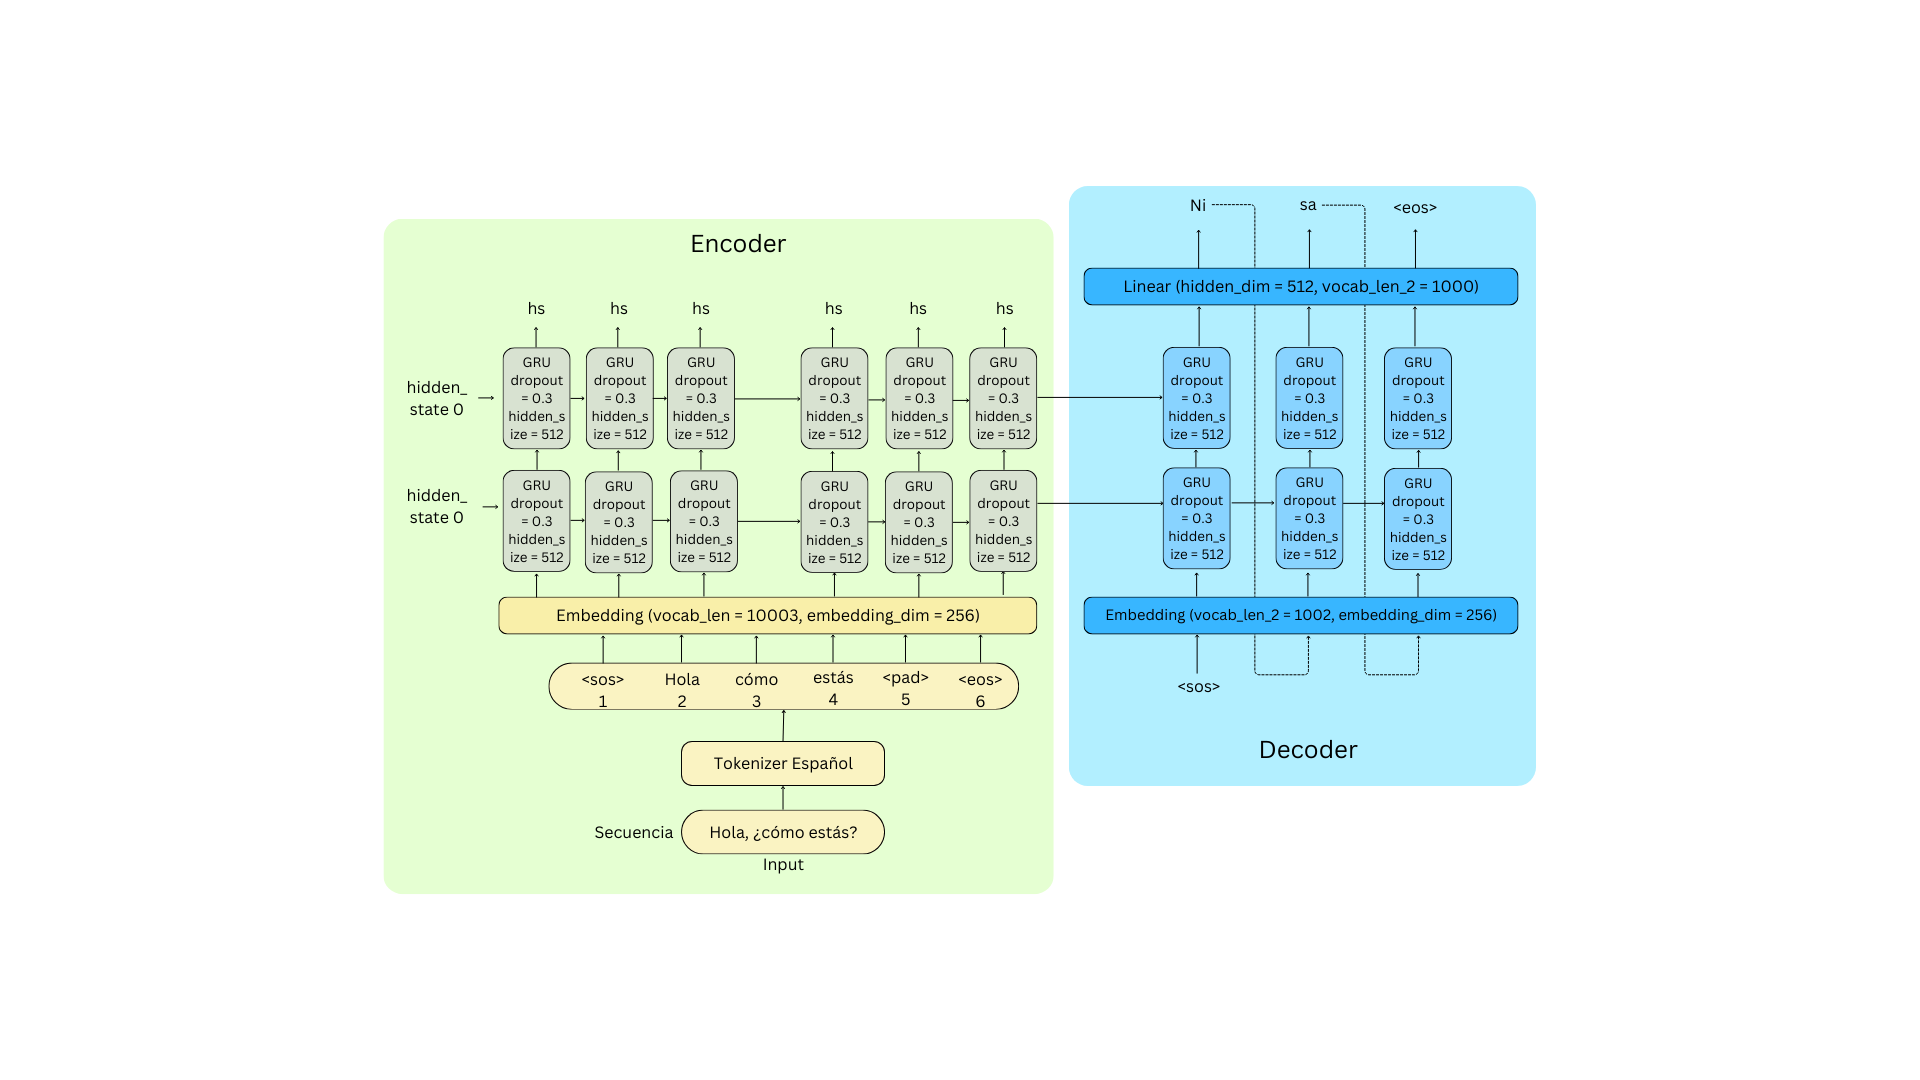

In [1]:
from IPython.display import Image
Image("Encoder-Decoder_Gru_2layer.png")

Se pueden definir como hiperparámetros principales a los siguientes elementos:
* GRU n_layers = 2
* GRU hidden_size = 512
* GRU dropout = 0.3
* vocab_len_input (del español) = 10.000 + 3
* embedding_dim_encoder = 256
* vocab_len_output (del Xanith) = 1.000 + 3
* embedding_dim_decoder = 256
* bidirectional = False
* largo de secuencia de entrada al entrenar = 6
* número se secuencias pasadas a la vez (tamaño del lote) = 3

Asimismo, es arbitraria la decisión de tokenizar por palabras e ignorar los signos de puntuación. Así como la decisión de incluir solo 10.000 palabras del castellano.
También el largo de la secuencia es un hiperparámetro, así como el tamaño del lote (que vendría a corresponder al número de secuencias que se le pasan, a la vez, al encoder, en este caso es igual a 3)

### (b) Se entrega una muestra de cómo sería el set de datos. ¿Qué tokens especiales agregaría para llevar esta tarea cumpliendo todos los supuestos dados? ¿Cómo quedaría la muestra del set de entrenamiento dada en la Tabla 1 luego de agregar dichos tokens?

En primer lugar es necesario incorporar los token especiales de \<sos>, \<eos> y \<pad> (comenzar una secuencia, terminar una secuencia y completar secuencia, respectivamente). Dejando así el vocab_len_input del Tokenizer de Español en 10.000 + 3 (tokens especiales). Se incluye el token especial \<pad> para poder trabajar en el encoder con secuencias de largo constante y en lotes, facilitando el cálculo en paralelo en GPUs. No hay que olvidar usar una máscara para que el modelo "ignore" estos valores a la hora de aprender.

Para el idioma Xanith, se agregarían \<sos> y \<eos>. No se agregaría \<pad> porque este no tiene sentido o significado literal en el idioma de salida, por lo que no tendría sentido el poder predecirlo de manera autoregresiva (asumamos que \<pad> no es una palabra del Xanith y que los otros tokens tampoco lo son) Por lo que el vocabulario de salida quedaría con 1.000 + 2 elementos.

Español | Xanith
--------|-------
\<sos> Hola cómo estás \<pad> \<eos> | \<sos> Ni sa \<eos>
\<sos> Vengo en son de \<eos> | \<sos> Lo ke da-paz \<eos>
\<sos> Me gustaría aprender Xanith \<eos> | \<sos> Lo si Xanith larn \<eos>

Nótese cómo se truncó la segunda frase, pasó de "Vengo en son de paz" a "Vengo en son de". Esto ocurrió porque se definieron secuencias de largo fijo igual a 6 y por la añadición de los tokens especiales \<sos> y \<eos>. Si no se hubiera cortado la última palabra ("paz") se habría
 superado el largo (habrían habido 7 tokens en vez de 6) Esta es una mejor opción que eliminar los tokens de \<sos> o \<eos> si el largo de secuencia máximo permitido se supera.

### (c) Muestre un ejemplo de Forward Pass con una de las frases al momento de entrenar. Explique claramente qué es lo que entra en el Encoder y el Decoder y qué es lo que sale del Decoder.

SE TOMAN VALORES TOKENIZADOS COMPLETAMENTE ARBITRARIOS SOLO PARA EJEMPLIFICAR. La gran diferencia entre el Forward Pass del encoder y del decoder en la fase de entrenamiento y la de testeo/predicción es que en el entrenamiento se debe aplicar una técnica para ajustar los pesos y reducir la función de pérdida (que puede ser Teacher Forcing tal como se aplicó en esta tarea). Tanto para validación y entrenamiento se tiene además una frase CONOCIDA en el idioma de salida, respecto a la cual se puede hacer la evaluación de la calidad de la predicción. En una fase de SOLO PREDICCIÓN no se conoce de antemano la secuencia (y por lo tanto su largo) que será generada por el decoder.

Durante el forward pass en entrenamiento, la frase de entrada al encoder podría ser `<sos> Hola cómo estás <pad> <eos>`, que es tokenizada como `[1, 3, 7, 10, 0, 2]` y pasa por el embedding, generando un tensor con dimensiones `(1, 6, 256)`. Este embedding entra a la GRU del encoder, produciendo una salida completa (`outputs`) con dimensiones `(1, 6, 512)` y un último estado oculto (`hidden`) con dimensiones `(2, 1, 512)`, que se pasa como contexto inicial al decoder. En el decoder, la secuencia esperada `<sos> Ni sa <eos>` (`[1, 4, 5, 2]`) se procesa un token a la vez mediante *teacher forcing*. Cada token entra al embedding del decoder, generando un tensor con dimensiones `(1, 1, 256)`, que pasa por la GRU para producir una salida del estado oculto `(1, 1, 512)`. Esta salida se proyecta linealmente al tamaño del vocabulario, generando un tensor de dimensiones `(1, 1, 1002)` por paso. Al final, todas las salidas del decoder se acumulan, formando un tensor con dimensiones `(1, 4, 1002)` que contiene las distribuciones de probabilidad para cada token de salida.

### (d) Muestre un ejemplo de Forward Pass pero al momento de predecir una nueva frase. Explique claramente qué es lo que entra en el Encoder y el Decoder y el proceso de Predicción Autoregresiva.

Durante el forward pass y para predecir una nueva frase (fase de inferencia), la frase de entrada al encoder podría ser, por ejemplo `<sos> Hola cómo estás <eos>`, tokenizada como `[1, 3, 7, 10, 2]` (sin `<pad>`). Esta secuencia se pasa por el embedding del encoder, generando un tensor con dimensiones `(1, 5, 256)`. El embedding entra a la GRU del encoder, produciendo una salida completa (`outputs`) con dimensiones `(1, 5, 512)` y un último estado oculto (`hidden`) con dimensiones `(2, 1, 512)`, que se pasa como contexto inicial al decoder. En el decoder, se inicia la generación autoregresiva con el token `<sos>` (`[1]`), que se pasa al embedding, generando un tensor de dimensiones `(1, 1, 256)`. Este embedding pasa por la GRU, produciendo un estado oculto `(1, 1, 512)`, que se proyecta al espacio del vocabulario, generando un tensor `(1, 1, 1002)` con las probabilidades para cada token del vocabulario. El token más probable (por ejemplo, `Ni` = 4) se selecciona, se pasa como entrada al siguiente paso del decoder, y el proceso se repite hasta generar el token `<eos>` o alcanzar la longitud máxima permitida. Las salidas del decoder se acumulan para formar un tensor final con dimensiones `(1, largo de secuencia de salida, 1002)`, que contiene las distribuciones de probabilidad de los tokens generados en cada paso.

### (e) Calcule explicitamente cuáles serían las dimensiones de los tensores de salida de las siguientes partes del modelo: Justifique su respuesta

Se calcularon estas dimensiones considerando los hiperparámetros seleccionados y asumiendo entrenamiento por lotes

* Input Embedding: Quedaría con dimensiones (número de secuencias, largo de secuencia, dimensión del embedding entrada). Es el producto de aplicar embedding a un tensor de tamaño
(número de secuencias, largo de secuencia), estando cada elemento de la secuencia ya tokenizado (convertido a un "índice numérico"). Para el modelo en particular las dimensiones del input embedding serían (3, 6, 256)

* Output embedding: Quedaría con dimensiones (número de secuencias, 1, dimensión del embedding salida). Es similar al Input Embedding pero en el Decoder definido se está pasando un token a la vez para así hacer las predicciones autoregresivas (esta dimensión coincide en el entrenamiento, incluso si solo se hace Teaching Forcing). Esto queda más claro en el archivo GRU.py. Para el caso particular las dimensiones serían (3, 1, 256)

* La salida del Encoder: Quedaría con dimensiones (número de secuencias, largo de secuencia, hidden size). Por lo menos pensando en la implementación en GRU.py, la salida correspondería a todos los outputs por tiempo t que el modelo va generando mientras recorre las secuencias de entrada. Para este ejemplo serían de (3, 6, 512) si se toman todos en su conjunto.

* El último hidden state del Encoder: Quedaría con dimensiones (número de capas, número de secuencias, hidden size). Es lo que aprende el Encoder y que finalmente entra (como contexto/nformación) al Decoder. Para el ejemplo en particular sería de (2, 3, 512)

* La salida del Decoder: De manera similar al encoder, corresponderían a los outputs que se va generando para cada hidden_state del decoder en cada tiempo t. Considerando cada output de manera individual y la pasada de un token a la vez para la predicción autoregresiva se tendrían dimensiones (número de secuencias, 1, hidden_sizee) = (3, 1, 512).

* Linear Projection: Es el resultado de aplicar un cambio dimensional a partir de una proyección lineal a la salida del Decoder, se pasa de dimensiones hidden_size no interpretables a vocab_output_size SÍ interpretables. Tiene dimensiones (número de secuencias, 1, vocab__size) = (3, 1, 1002)

* Output de la Red (justo antes de entrar al Loss Function): Vendrían siendo todas las salidas de las linear projection pero "concatenadas". Tendrían dimensiones (3, 6, 1002) (el "1" de Linear Projection se reemplazó por el "6" que corresponde al largo de la secuencia.)"

### (f) Implemente el diseño propuesto en Pytorch creando una clase que herede de nn.Module y muestre en pantalla el número de parámetros del modelo. Guarde el código en el archivo GRU.py. Con dichos resultados, responda la siguiente pregunta: ¿Cuál sería el número de Parámetros del Encoder, del Decoder y del Linear Projection?

Se obtuvo a partir del archivo .py lo siguiente:

* Parámetros del Encoder: 5.319.424
* Parámetros del Decoder: 3.529.194
* Parámetros de la Proyección Lineal (Linear Projection): 514.026
* Parámetros totales: 8.848.618

Lo cual tiene sentido considerando que el vocabulario de entrada es más grande que el de salida (hay más parámetros en el encoder que en el decoder)